In [2]:
""" 
*** Functions for tiling ***
"""
import math
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# p = (RA, DEC)
def Equi2Cart(p):
    alpha = np.radians(p[0])
    delta = np.radians(p[1])
    x = np.cos(alpha) * np.cos(delta)
    y = np.sin(alpha) * np.cos(delta)
    z = np.sin(delta)
    return [x, y, z]
    # returns a vector in cartesian

# v = [x, y, z]
def Cart2Equi(v):
    x, y, z = v[0], v[1], v[2]
    ra = np.rad2deg(math.atan2(y,x))
    dec = np.rad2deg(math.asin(z))
    return [ra, dec]
    # returns a point in equitorial

# rotate about tile center
def rotate(angle):
    theta = np.radians(angle)
    Rx = [[1, 0, 0],
          [0, np.cos(theta), -np.sin(theta)],
          [0, np.sin(theta), np.cos(theta)]]
    return Rx

# move the center of the tile to the desired equatorial coordinates
def move(RA, DEC):
    alpha = np.radians(RA)
    delta = np.radians(DEC)
    # move to DEC coordinate
    Ry = [[np.cos(delta), 0, -np.sin(delta)],
          [0, 1, 0],
          [np.sin(delta), 0, np.cos(delta)]]
    # move to RA coordinate
    Rz = [[np.cos(alpha), -np.sin(alpha), 0],
          [np.sin(alpha), np.cos(alpha), 0],
          [0, 0, 1]]
    return np.matmul(Rz, Ry)

# coordinates of each CCD of the tile = [CCD1, CCD2, CCD3, CCD4]
def CCD_array(l=900/3600, w=860/3600, g=26/3600):
    RA = {1: g/2 + l, 2: g/2 + l, 3: g/2, 4: g/2, 5: g/2 + l, 6: g/2 + l, 7: g/2, 8: g/2, 
          9: -g/2, 10: -g/2, 11: -(g/2 + l), 12: -(g/2 + l), 13: -g/2, 14: -g/2, 15: -(g/2 + l), 16: -(g/2 + l)}
    DEC = {1: -(g/2 + w), 2: -g/2, 3: -g/2, 4: -(g/2 + w), 5: g/2, 6: g/2 + w, 7: g/2 + w, 8: g/2,
           9: g/2, 10: g/2 + w, 11: g/2 + w, 12: g/2, 13: -(g/2 + w), 14: -g/2, 15: -g/2, 16: -(g/2 + w)}
    tile = [[] for _ in range(4)]
    for i in range(1, 17):
        tile[(i - 1) // 4].append(Equi2Cart((RA[i],DEC[i])))
    return tile

# the projected length at a given declination 
def ProjDec(length, DEC):
    p = [length, 0]
    pp = Cart2Equi(np.matmul(move(0, DEC), Equi2Cart(p)))
    return pp[0]

# returns a tile multipolygon, the intersection ratio between the tile and footprint
def per_tile(footprint, RA, DEC, angle=0, l=900/3600, w=860/3600, g=26/3600):
    CCDs = []
    tile = CCD_array(l, w, g)
    inter_area = 0
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(angle), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        # create polygon for each CCD in the CCD_array
        vertices = [(x, y) for x, y in zip(ra, dec)]
        polygon = Polygon(vertices)
        # each CCD's intersection with the footprint
        CCD_footprint = polygon.intersection(footprint)
        inter_area += CCD_footprint.area
        CCDs.append(polygon)
    # each tile is a multipolygon
    mp = MultiPolygon(CCDs)
    tile_area = mp.area  # each tile's area
    intersect_ratio = inter_area / tile_area
    return mp, intersect_ratio


### Tiling Strategy: Vertical Snake Scan

In [3]:
""" 
*** Vertical snake scan *** 
"""

def SnakeScanTiling(coords, survey_color, min_intersect_ratio, tile_overlap=30/3600, l=900/3600, w=860/3600, g=26/3600):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    #ax.plot(coords[:, 0], coords[:, 1], linewidth=0.8, color='black', label="footprint boundary")
    
    footprint = Polygon(coords)
    xmin, ymin, xmax, ymax = footprint.bounds
    
    # avoid computing tiles at the [-180, 180] boundary
    if xmin < -179.9:
        xmin = -179.9
    if xmax > 179.9:
        xmax = 179.9
    
    slew_length = (2*l + g) - tile_overlap
    slew_width = (2*w + g) - tile_overlap
    DECvals = np.arange(ymin+w, ymax+w, step=slew_width)
    
    # collect valid tile center coords in tiling sequence
    tile_centers = [] 
    RAvals = []
    max_length = 0 
    
    for DEC in DECvals:
        # calculate the RAs for a given DEC
        RArow = np.arange(xmin + ProjDec(l, DEC), xmax + ProjDec(l, DEC), step=ProjDec(slew_length, DEC))
        max_length = max(max_length, len(RArow))
        RAvals.append(RArow)
    
    # add NaN to make each row the same length
    for i in range(len(RAvals)):
        diff = max_length - len(RAvals[i])
        if diff > 0:
            RAvals[i] = np.append(RAvals[i], [math.nan]*diff)
    
    # transpose the tiling sequence from 'by rows' to 'by columns'
    RAvals = np.array(RAvals).T
    
    for n, RAcolumn in enumerate(RAvals):
        column = []
        for (RA, DEC) in zip(RAcolumn, DECvals):
            if np.isnan(RA) == False:
                tile_obj, intersect_ratio = per_tile(footprint, RA, DEC)
                if intersect_ratio >= min_intersect_ratio:
                    column.append((RA, DEC))
                    for geom in tile_obj.geoms:
                        xs, ys = geom.exterior.xy
                        ax.fill(xs, ys, alpha=0.5, color=survey_color, ec=None)
        # snake scan
        if n % 2 != 0:
            column = column[::-1]
        tile_centers.append(column)
    
    tile_centers = [j for i in tile_centers for j in i]
    tile_num = len(tile_centers)
    ax.plot(*zip(*tile_centers), linewidth=0.5, color='tab:red')
    ax.scatter(*zip(*tile_centers), s=5, color='black')
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    
    return tile_centers

In [8]:
"""
*** Functions for tracking time and calculating observing efficiency ***
"""
import math 

# Find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time

def Seconds2Day(time):
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    return day, hour, minutes, seconds

# Convert time elapsed in an orbit (sec.) --> telescope's position (degrees) in an orbit around the Earth
# Angle theta starts in the East (viewed facing sun) going CCW; always between 0° to 360°
def Position(orbitTimeTrack):
    period = 100.9 # min
    # orbitTimeTrack is time elapsed from startAngle 
    theta = (orbitTimeTrack/60/period)*360 # degrees
    return theta

# the time passed (in sec.) while the telescope moves a given angle in the orbit
def PassedTime(angle):
    period = 100.9 # min
    return (angle/360)*period*60
    
# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

# With theta = 0° at positive RA (x-axis) direciton, (i.e. starts in the East viewed facing sun) going CCW
# satellite position = (x0, y0) where y0 = -7.8
# target = tile_center coords (x, y)
def ViewingZone(x0, target):
    y0 = -7.8
    x, y = target[0], target[1]
    xp = x - x0
    yp = y - y0
    # the direction where the boresight is pointing 
    theta = math.degrees(math.atan2(yp, xp))
    theta = (theta + 360) % 360
    # the angular distance the pointing is away from CVZ
    theta_b = math.sqrt(xp**2 + yp**2)
    #print('angle away from CVZ center:', theta_b)
    frac = ViewingFrac(theta_b)
    #print('viewing efficiency:', frac)
    halfVisAngle = frac*180 # degrees
    zone = [(theta-halfVisAngle+360)%360, (theta+halfVisAngle+360)%360]
    return zone

# Determine the types of viewing zone
def ZoneType(index, startzone, endzone):
    # three types of viewing zone
    if endzone-startzone > 10**-5:
        # the viewing zone is continuous, where startzone < endzone
        type = 1
        print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    elif round(startzone,5) == round(endzone,5):
        # the tile is in CVZ
        type = 2
        print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    else:
        # the viewing zone wraps around from 360° to 0° 
        type = 3
        print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
    return type

def AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime):
    if startzone > theta:
        dead_time = PassedTime(startzone-theta+0.0001)
    else:
        dead_time = PassedTime(360-theta+startzone+0.0001)
    place_holder.append([dead_time, [theta, startzone+0.0001]])
    ElapsedTime += dead_time
    dayTimeTrack += dead_time
    orbitTimeTrack += dead_time
    dataTimeTrack += dead_time
    DeadTime += dead_time
    print('Dead time:', round(dead_time,2), 's')
    print()
    return place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime

# Calculate how much time is available in the current viewing cycle
def TimeAvailable(type, endzone, theta): 
    if type==1:
        time_available = PassedTime(endzone-theta)
    elif type==2:
        time_available = PassedTime(360) # if the tile is in CVZ, there is infinite time available
    else:
        if endzone > theta:
            time_available = PassedTime(endzone-theta)
        else:
            time_available = PassedTime(360-theta+endzone)
    return time_available

# Update the time spend on moving to the tile and imaging
# need to specify which of the actions(slew, settle, and exposure) are included in this update
def Update4Imaging(slew, settle, Exposure, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack):
    overhead_time += slew + settle
    exposure_time += Exposure
    ElapsedTime += Exposure + slew + settle
    dayTimeTrack += Exposure + slew + settle
    orbitTimeTrack += Exposure + slew + settle
    dataTimeTrack += Exposure + slew + settle
    return overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack

""" Time Trackers in the WideObserving code """
# Track Data
def TrackData(overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data):
    # Data Info
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/4
    downlink_rate = 10/8 # GBps
    # max downlink window
    downlink_window = 5*60 # seconds
    downlink_max = downlink_rate * downlink_window # GB
    datacap = 440 # GB
    
    if dataTimeTrack >= 12*3600:
        data_capacity = round((onboard_data/datacap)*100, 1)
        # data >= 375 GB
        if onboard_data >= downlink_max:
            #print(f'<< Downlinking Data takes {downlink_window/60 + 1} min. >>')
            #print()
            overhead_time += downlink_window + 1*60
            ElapsedTime += downlink_window + 1*60
            dayTimeTrack += downlink_window + 1*60
            downlinked_data += downlink_max
            onboard_data -= downlink_max
        # data < 375 GB
        else:
            #print(f'<< Downlinking Data takes {(onboard_data/downlink_rate)/60 + 1} min. >>')
            #print()
            overhead_time += (onboard_data/downlink_rate) + 1*60
            ElapsedTime += (onboard_data/downlink_rate) + 1*60
            dayTimeTrack += (onboard_data/downlink_rate) + 1*60
            downlinked_data += onboard_data
            onboard_data = 0
        dataTimeTrack = 0 
    return overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data

# Track Orbit around Earth
def TrackOrbit(orbitTimeTrack, orbit_num):
    period = 100.9 # min
    # onto the the next orbit
    if orbitTimeTrack >= period*60:
        orbit_num += 1
        #print(f'{round(orbitTimeTrack/60,2)} min. passed --> entering new orbit')
        #print()
        orbitTimeTrack -= period*60
    return orbitTimeTrack, orbit_num

# Track Day: update satellite position across RA every day
def TrackDay(dayTimeTrack, day_num, sat_position, tile):
    daily_step = 360/365 # CVZ center movement across RA per day
    if dayTimeTrack >= 24*60*60:
        day_num += 1
        sat_position += daily_step
        print()
        print(f'\033[1m{round(dayTimeTrack/60/60,2)} hrs passed --> a new day\033[0m')
        print(f"\033[1msatellite's RA = {sat_position}°\033[0m")
        print(f'\033[1mviewing tiles on RA ~ {tile[0]}°\033[0m')
        print()
        dayTimeTrack = 0
    return dayTimeTrack, day_num, sat_position

In [9]:
""" Euclid Deep Field has exposure time of 18000s = 72x250s per tile """

# input the vertices (in equitorial coords) of the un-projected footprint shape 
# choose which survey is getting projected
def Project(footprint, survey_center):
    RA, DEC = survey_center[0], survey_center[1]
    proj_footprint = []
    for vertex in footprint:
        proj_vertex = Cart2Equi(np.matmul(move(RA, DEC), Equi2Cart(vertex)))
        proj_footprint.append(proj_vertex)
    return np.array(proj_footprint)


def DeepFieldObserving(footprint, survey_color, survey_center, min_intersect_ratio, days_ahead, startAngle, exposure, settle=90):
        
    tile_sequence = [] # a list of tile coordinates in their imaging order
    # should end up being the same as tile_centers
    
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    # sub-exposures of 250s
    exposure_parts = 250 # seconds
    parts_num = int(exposure / exposure_parts)
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/parts_num
    
    # all time are in seconds if not specified
    """ Time Tracker """
    dayTimeTrack = 0
    orbitTimeTrack = 0
    dataTimeTrack = 0 
    DeadTime = 0
    ElapsedTime = 0
    
    """ Info Tracker """
    overhead_time = 0
    exposure_time = 0
    onboard_data = 0 # GB
    downlinked_data = 0 # GB
    orbit_num = 0
    day_num = 0
    
    # stores the remaining exposures of each tile in imaging order 
    remain_vals = [] 

    # Tiling the survey footprint with vertical snake scan 
    proj_footprint = Project(footprint, survey_center)
    tile_centers = SnakeScanTiling(proj_footprint, survey_color, min_intersect_ratio)
    print(f'there are {len(tile_centers)} tiles in this survey')
    # tile index
    index = 1
    
    # start the satellite's RA position "days_ahead" the left-most tile of the wide survey
    daily_step = 360/365 # CVZ center movement across RA per day
    sat_position = tile_centers[0][0] - days_ahead*daily_step
    start_sat = sat_position
    print(f"satellite's starting RA = {start_sat}°")
    
    """ BEGIN OBSERVING HERE: going through all the tiles """
    while tile_centers or remain_vals:
        if remain_vals == []:
            # Update telescope position
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            print(f'telescope position around Earth = {round(theta,4)}°')
    
            # Select a tile in the order of the vertical snake scan
            tile = tile_centers.pop(0)
    
            # Find the tile's viewing zone based on the satellite RA position 
            zone = ViewingZone(sat_position, tile)
            startzone, endzone = zone[0], zone[1]
            type = ZoneType(index, startzone, endzone)
    
            # When the telescope is NOT in the selected tile's viewing zone, WAIT until it is in the zone
            if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
                """ Add dead time """
                place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                theta = (Position(orbitTimeTrack) + startAngle) % 360
                print(f'telescope position around Earth = {round(theta,4)}°')
            
            """ Track Orbit """
            orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
            """ Track Day """
            dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
            
            # When the telescope IS in the selected tile's viewing zone, allow imaging
            # But first, check if there's enough time left to complete at least one exposure segment 
            time_available = TimeAvailable(type, endzone, theta)
            time_used = 0
            if index != 1:
                angle = Haversine(tile_sequence[-1], tile)
                slew = Angle2Time(angle)
                time_used = slew + settle
            time_left = time_available - time_used
    
            # Not enough time
            if time_left < exposure_parts:
                print(f'time available for imaging in this orbit: {round(time_left,4)}s, NOT enough time')
                tile_centers = [tile] + tile_centers    
                """ Add dead time """
                place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                continue # go straight to the next "while loop" iteration
            
            # Enough time
            else:
                # Slew to the tile
                if index != 1:
                    print('slew + settle takes', slew + settle, 's')
                    """ Update Time - moving to the tile """
                    overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack)
                    
                print(f'time available for imaging in this orbit: {round(time_left,4)}s')
                print('enough time to complete at least one sub-exposure')
                print()
                tile_sequence.append(tile)
    
                # Determine how many of the segmented exposures can be completed
                print('*** IMAGING ***')
                Exposure = 0
                while Exposure < exposure and exposure_parts < time_left :
                    Exposure += exposure_parts
                    print('exposure =', Exposure, 's')
                    time_left -= exposure_parts
                    print('time left =', round(time_left,2), 's')
                    onboard_data += data_parts
                print('\033[1mCompleted exposure =\033[0m', Exposure, 's')
                """ Update Time - imaging tile """
                overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, Exposure, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack)
        
                # Determines if there are remaining exposures
                if Exposure == exposure:
                    exposure_remain = 0
                    print(f'<< tile {index} COMPLETED >>')
                    # the index for the next tile
                    index += 1
                    print('going to tile', index)
                    print()
                else:
                    exposure_remain = exposure - Exposure
                    print('Remaining exposure =', exposure_remain, 's')
                    print()
                    remain_vals.append(exposure_remain)
    
            """ Track Data """
            overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data = TrackData(overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data)
            """ Track Orbit """
            orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
            """ Track Day """
            dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
              
        # For the tile with remaining exposures
        else:
            exposure_remain = remain_vals.pop()
            
            # Update telescope position
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            print(f'telescope position around Earth = {round(theta,4)}°')

            # Add dead time so the telescope is in a new viewing cycle
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            """ Track Orbit """
            orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
            """ Track Day """
            dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
          
            # Update telescope position
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            print(f'telescope position around Earth = {round(theta,4)}°')

            # available viewing time
            time_available = TimeAvailable(type, endzone, theta)
            print('time available for imaging in this orbit:', round(time_available,4), 's')
                    
            Exposure = 0
            while exposure_remain != 0 and exposure_parts < time_available :
                exposure_remain -= exposure_parts
                Exposure += exposure_parts
                print('exposure =', Exposure, 's')
                time_available -= exposure_parts
                print('time available =', round(time_available,2), 's')
                onboard_data += data_parts
            print('\033[1mCompleted exposure =\033[0m', Exposure, 's')
            """ Update Time - imaging tile """
            overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, Exposure, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack)

            # Determines if there are remaining exposures
            if exposure_remain == 0:
                print(f'<< tile {index} COMPLETED >>')
                # the index for the next tile
                index += 1
                print('going to tile', index)
                print()
            else:
                print('Remaining exposure =', exposure_remain, 's')
                print()
                remain_vals.append(exposure_remain)
            
            """ Track Orbit """
            orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
            """ Track Day """
            dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
    
    # When all tiles are completed
    end_sat = sat_position
    sat_range = (start_sat, end_sat) # the RA range that the satellite moved while completing the survey
    print(f'satellite covered an RA range of {round(start_sat,2)}° - {round(end_sat,2)}°')
    index -= 1
    print(f'{index} tiles successfully imaged')
    print('currently on orbit', orbit_num+1, 'around Earth')
    print()
    
    print(f'* exposure time: {exposure_time}s = {round(exposure_time/3600,2)} hrs')  
    print(f'* overheads (slew + settle + downlink data): {round(overhead_time/3600,2)} hrs')
    print(f'\033[1m* Total dead time: {round(DeadTime/3600,2)} hrs\033[0m')
    print('\033[1mTotal Elapsed Time = exposure + overheads + deadtime\033[0m')
    print(Seconds2Day(ElapsedTime))
    Efficiency = (exposure_time / ElapsedTime)*100
    MaxEfficiency = (exposure_time + DeadTime/3) / ElapsedTime * 100
    print(f'\033[1mObserving Efficiency: {round(Efficiency,2)}%\033[0m')
    print(f'Assume we can \033[1mrecover one third of the deadtime\033[0m, the observing efficiency is: \033[1m{round(MaxEfficiency,2)}%\033[0m')
    print(f'Data onboard: {round(onboard_data,2)} GB')
    print(f'Data downlinked: {round(downlinked_data,2)} GB')
    
    return sat_range, tile_sequence, place_holder, Efficiency

In [10]:
""" 
*** Survey Coordinates ***
"""

from shapely.geometry import Polygon
import numpy as np

# Coordinates Conversions
def RAdeg(hr, min, sec):
    degrees = (hr + min/60 + sec/3600) * 15
    return degrees
def DECdeg(deg, arcmin, arcsec):
    degrees = deg + arcmin/60 + arcsec/60
    return degrees
# Normalize RA values to the range [-180, 180] degrees.
def normalize_ra(ra):
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra

# The center coordinates of the two Euclid Deep Fields
EDFN = [normalize_ra(RAdeg(17,58,56)), DECdeg(66,1,3.7)]
EDFS = [RAdeg(4,4,58), DECdeg(-48,25,23)]

# the footprint when centered at RA = 0 and DEC = 0 
footprint = np.loadtxt('EDFN.txt')
# choose survey
survey_center = EDFN
survey_color = 'darkorange'
# choose the min. required intersection between the tile and the footprint 
EDFN_ratio = 0.01
EDFS_ratio = 0.3
min_intersect_ratio = EDFN_ratio

there are 80 tiles in this survey
satellite's starting RA = -100.66031169682098°
telescope position around Earth = 0.0°
tile 1's viewing zone: [337.9041°, 360°] [0°, 194.2827°] 
time available for imaging in this orbit: 3267.1874s
enough time to complete at least one sub-exposure

*** IMAGING ***
exposure = 250 s
time left = 3017.19 s
exposure = 500 s
time left = 2767.19 s
exposure = 750 s
time left = 2517.19 s
exposure = 1000 s
time left = 2267.19 s
exposure = 1250 s
time left = 2017.19 s
exposure = 1500 s
time left = 1767.19 s
exposure = 1750 s
time left = 1517.19 s
exposure = 2000 s
time left = 1267.19 s
exposure = 2250 s
time left = 1017.19 s
exposure = 2500 s
time left = 767.19 s
exposure = 2750 s
time left = 517.19 s
exposure = 3000 s
time left = 267.19 s
exposure = 3250 s
time left = 17.19 s
Completed exposure = 3250 s
Remaining exposure = 14750 s

telescope position around Earth = 193.2607°
Dead time: 2432.42 s

telescope position around Earth = 337.9042°
time available for ima

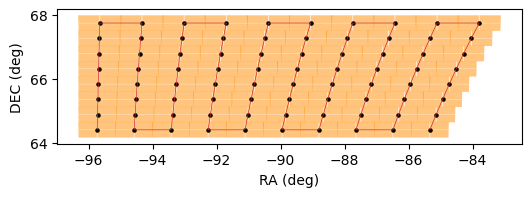

In [11]:
# Calculate the observing efficiency
days_ahead = 5
startAngle = 0
exposure = 18000
sat_range, tile_sequence, place_holder, Efficiency = DeepFieldObserving(footprint, survey_color, survey_center, min_intersect_ratio, days_ahead, startAngle, exposure)

Total deadtime = 17355.36681364152 min.


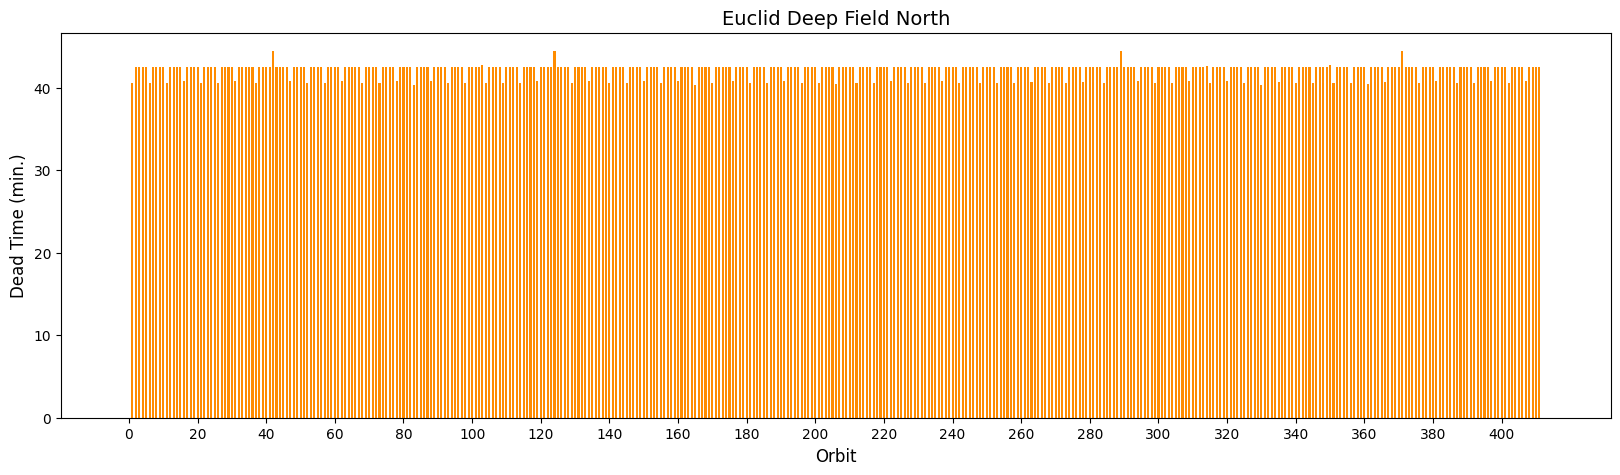

In [34]:
import matplotlib.pyplot as plt

orbitnum = len(place_holder)
deadtime = []
for i in place_holder:
    deadtime.append(i[0])

print(f'Total deadtime = {sum(deadtime)/60} min.')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
x = np.arange(1,orbitnum+1)
y = np.array(deadtime)/60
bars = ax.bar(x, y, color='darkorange', width=0.6)
xticks = range(0, orbitnum, 20)
# xlabels = x[::10]
ax.set_xticks(xticks)
# ax.set_xticklabels(xlabels)  
ax.set_xlabel('Orbit', fontsize=12)
ax.set_ylabel('Dead Time (min.)', fontsize=12)
ax.set_title('Euclid Deep Field North', fontsize=14)
plt.show()